In [56]:
import keras
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from scipy.stats import percentileofscore, rankdata
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import pickle as pkl
from functools import partial
from tqdm import tqdm_notebook

sns.set_style("darkgrid")
%matplotlib inline

In [57]:
DATA_PATH = "../Cardiac_muscle/"
MARKS = ["H3K4me3", "H3K9me3", "H3K36me3", "H3K27me3", "H3K27ac", "H3K4me1"]
SIZE = "100"
state = 100

## Model

In [7]:
def get_autoencoder(inside, optimizer, loss):
    input_img = Input(shape=(6,))
    encoded = Dense(4, activation=inside)(input_img)
    encoded = Dense(2, activation=inside)(encoded)
    decoded = Dense(4, activation=inside)(encoded)
    decoded = Dense(6, activation='sigmoid')(decoded)
    deep_autoencoder = Model(input_img, decoded)
    deep_autoencoder.compile(optimizer=optimizer, loss=loss) 
    encoder = Model(input_img, encoded)
    return deep_autoencoder, encoder

In [8]:
insides = ["sigmoid", "relu"]
optimizers = ["adadelta", "adam", "nadam", "adamax", "adagrad"]

In [9]:
autoencoder_dict = dict()
for inside in insides:
    for optimizer in optimizers:
        autoencoder_dict[(inside, optimizer)] = get_autoencoder(inside, optimizer, "mse")

In [10]:
autoencoder_dict[("sigmoid", "nadam")][0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 6)                 0         
_________________________________________________________________
dense_69 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_70 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_71 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_72 (Dense)             (None, 6)                 30        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


## Dataset

In [58]:
first_chrom = dict()
for mark in MARKS:
    with open("{}{}_100.pkl".format(DATA_PATH, mark), "rb") as mark_file:
        first_chrom[mark] = pkl.load(mark_file)

In [59]:
for mark in first_chrom:
    where_nans = np.isnan(first_chrom[mark])
    first_chrom[mark][where_nans] = 0

In [ ]:
first_chrom_df = pd.DataFrame(first_chrom)
first_chrom_scaled = pd.DataFrame(scale(first_chrom_df), columns=first_chrom_df.columns)

In [61]:
# first_nonzero = first_chrom_df[first_chrom_df.apply(sum, axis=1) != 0]
first_nonzero = pd.read_hdf("../Cardiac_muscle/first_nonzero.hdf")

In [16]:
first_nonzero.to_hdf("../Cardiac_muscle/first_nonzero.hdf", "w")

In [63]:
genes = pd.read_hdf("../Labels/ensembl_CDSs.hdf")
labels_nonzero = genes[first_nonzero.index]
labels_nonzero.index = range(len(labels_nonzero))

In [64]:
first_nonzero.head()

,H3K27ac,H3K27me3,H3K36me3,H3K4me1,H3K4me3,H3K9me3
98,0.000000,0.000000,0.000000,0.000000,0.000000,0.032607
99,0.134452,0.071357,0.150166,0.000000,0.178754,0.166953
100,0.409484,0.331994,0.257893,0.010391,0.527132,0.828330
101,1.106421,0.888328,0.233954,0.135092,0.825033,2.003630
102,1.508669,1.465509,0.462926,0.490447,1.117832,2.107487


In [65]:
len(first_nonzero)

2206482

In [66]:
def get_quant(column, row):
    return percentileofscore(first_chrom_scaled[column], row[column])

In [67]:
quant_scaled = pd.DataFrame()
for column in tqdm_notebook(first_nonzero.columns):
    print(column)
    quant_scaled[column] = rankdata(first_nonzero[column], method="average") / len(first_nonzero)
#     quantilize = partial(get_quant, column)
#     quant_scaled[column] = first_chrom_scaled.apply(quantilize, axis=1)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

H3K27ac
H3K27me3
H3K36me3
H3K4me1
H3K4me3
H3K9me3



In [68]:
x_train, x_test = train_test_split(quant_scaled, test_size=0.2, random_state=state)

In [69]:
x_train.head()

,H3K27ac,H3K27me3,H3K36me3,H3K4me1,H3K4me3,H3K9me3
1453965,0.571852,0.915979,0.801637,0.313480,0.846220,0.992860
1915671,0.691489,0.829418,0.880634,0.477877,0.550437,0.919766
1660602,0.916550,0.292676,0.737345,0.948688,0.466556,0.816524
470680,0.754725,0.992119,0.422752,0.422723,0.574312,0.613865
442690,0.542691,0.046222,0.934821,0.428091,0.952296,0.609962


## Train dat shit

In [ ]:
dim_dict = dict()
for key, (autoencoder, encoder) in autoencoder_dict.items():
    autoencoder.fit(x_train, x_train,
                    epochs=20,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test))
    dim_dict[key] = zip(*encoder.predict(quant_scaled))

In [24]:
autoencoder_dict[("sigmoid", "nadam")][0].fit(x_train.values, x_train.values,
                                              epochs=100,
                                              batch_size=256,
                                              shuffle=True,
                                              validation_data=(x_test, x_test))

Train on 1765185 samples, validate on 441297 samples
Epoch 1/100
1765185/1765185 [==============================] - 9s 5us/step - loss: 0.0457 - val_loss: 0.0384
Epoch 2/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0383 - val_loss: 0.0381
Epoch 3/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0382 - val_loss: 0.0381
Epoch 4/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0381 - val_loss: 0.0381
Epoch 5/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0381 - val_loss: 0.0381
Epoch 6/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0380 - val_loss: 0.0379
Epoch 7/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0376 - val_loss: 0.0369
Epoch 8/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0363 - val_loss: 0.0359
Epoch 9/100
1765185/1765185 [==============================] - 8s 5us/step 

1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 76/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0341
Epoch 77/100
1765185/1765185 [==============================] - 8s 4us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 78/100
1765185/1765185 [==============================] - 8s 4us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 79/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 80/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 81/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 82/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 83/100
1765185/1765185 [==============================] - 8s 5us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 84/100
1765185/17

In [25]:
x, y = zip(*autoencoder_dict[("sigmoid", "nadam")][1].predict(quant_scaled))

In [29]:
auto_df = pd.DataFrame({"x": x, "y": y})

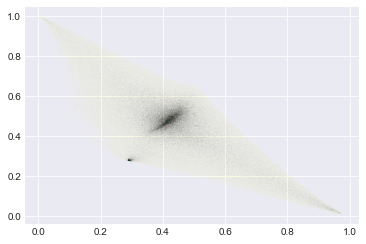

In [38]:
plt.scatter(x, y, alpha=0.007, s=0.1, c=labels_nonzero, cmap="YlGn")

## PCA stuff

In [28]:
pca = PCA(n_components=2)

In [34]:
auto_pca_arr = pca.fit_transform(auto_df)
auto_pca_df = pd.DataFrame(auto_pca_arr, columns=["x", "y"])

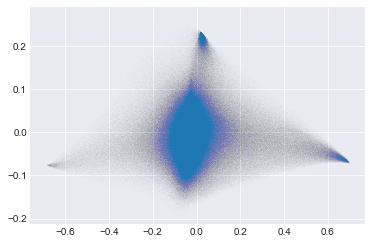

In [35]:
plt.scatter(auto_pca_df["x"], auto_pca_df["y"], alpha=0.007, s=0.1)

## TSNE stuff

In [61]:
x, y = dim_dict[("sigmoid", "nadam")]

In [84]:
first_nonzero["auto_x"] = x
first_nonzero["auto_y"] = y

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [87]:
first_nonzero_scaled = pd.DataFrame(scale(first_nonzero), columns=first_nonzero.columns)

In [88]:
first_nonzero_scaled.to_hdf("../Models/first_nonzero_scaled.hdf", key="w")

In [89]:
def lol_sum(row):
    return sum(row[:-2])

In [47]:
first_nonzero = first_chrom_df[first_chrom_df.apply(lol_sum, axis=1) != 0]
first_nonzero_scaled = pd.DataFrame(scale(first_nonzero), columns=first_chrom_df.columns)

In [39]:
little_all_scaled = first_scaled_all.sample(n=6000, random_state=state)

In [98]:
little_nonzero_scaled = first_nonzero_scaled.sample(n=6000, random_state=state)

In [99]:
tsne = TSNE(random_state=state)

In [100]:
lol_table = tsne.fit_transform(little_nonzero_scaled)

In [101]:
lol_x, lol_y = zip(*lol_table)

In [ ]:
plt.scatter(x, y, alpha=1)

In [45]:
first_chrom_df.head()

,H3K27ac,H3K27me3,H3K36me3,H3K4me1,H3K4me3,H3K9me3
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
labels_nonzero[labels_nonzero == 0] = -1

In [54]:
sum(labels_nonzero) / len(labels_nonzero)

-0.9192660533827152

In [ ]:
plt.scatter(x, y, alpha=0.1, s=0.2, c=labels_nonzero, cmap="binary")

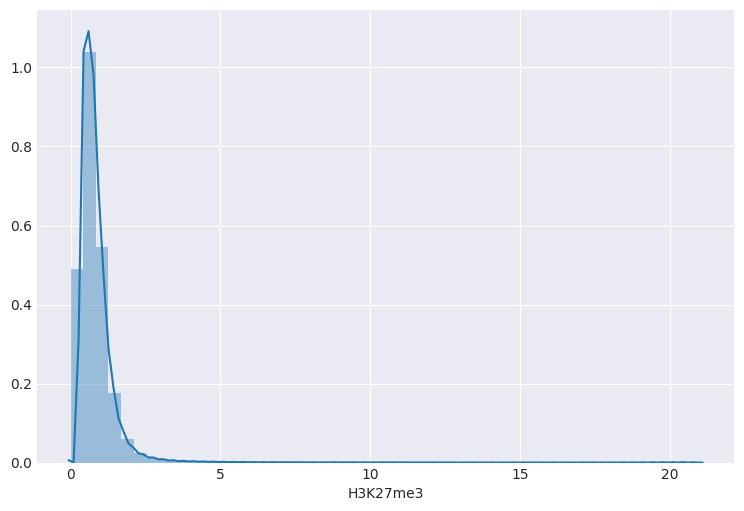

In [104]:
sns.distplot(first_nonzero["H3K27me3"])

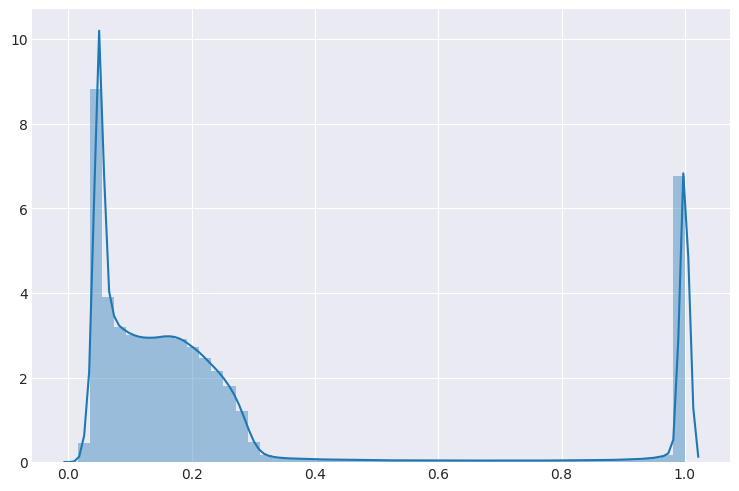

In [67]:
sns.distplot(x)

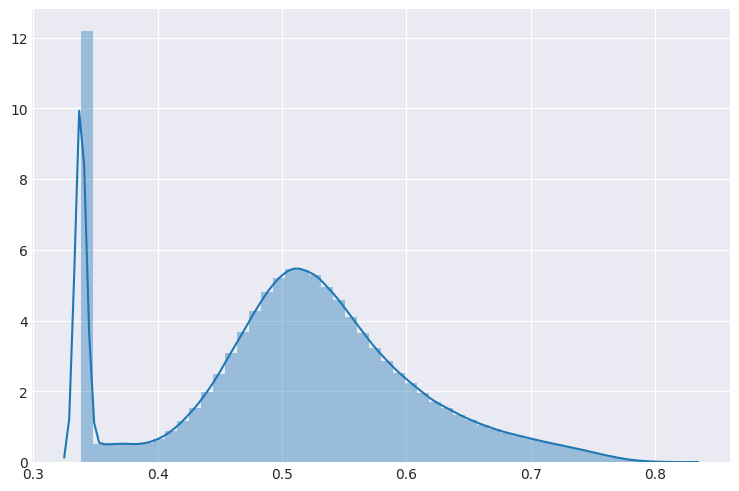

In [68]:
sns.distplot(y)

# DEEEEEEEC

In [205]:
from scipy import optimize
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
import pickle as pkl

In [31]:
from keras.optimizers import SGD
from keras.layers import Input, Dense
from keras.models import Model, Sequential

In [13]:
inp = Input(shape=(8,))
encoded = Dense(4)(inp)
decoded = Dense(8)(encoded)
model = Model(inp, decoded)
model.compile(optimizer="nadam", loss="mse")

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 40        
Total params: 76.0
Trainable params: 76.0
Non-trainable params: 0.0
_________________________________________________________________


In [207]:
with open("../Models/dec.pkl", "wb") as dec_file:
    pkl.dump(dec, dec_file)

TypeError: can't pickle _thread.lock objects

In [208]:
stacked_ae = Sequential()
for enc_layer in dec.enc_list:
    stacked_ae.add(enc_layer)
for dec_layer in reversed(dec.dec_list):
    stacked_ae.add(dec_layer)

In [211]:
stacked_ae.compile(optimizer="nadam", loss="mse")

In [212]:
stacked_ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_146 (Dense)            (None, 5)                 35        
_________________________________________________________________
dense_147 (Dense)            (None, 4)                 24        
_________________________________________________________________
dense_148 (Dense)            (None, 3)                 15        
_________________________________________________________________
dense_149 (Dense)            (None, 2)                 8         
_________________________________________________________________
dense_153 (Dense)            (None, 3)                 9         
_________________________________________________________________
dense_152 (Dense)            (None, 4)                 16        
_________________________________________________________________
dense_151 (Dense)            (None, 5)                 25        
__________

In [213]:
stacked_ae.save("../Models/stacked_ae.hdf5")

In [147]:
class DEC():
    
    def __init__(self, train_data, test_data, SAE_code, denoise, optimizer, batch_size, 
                 activation, ae_loss):
        self.SAE_code = list(map(int, SAE_code))
        self.train_data = {self.SAE_code[0]: train_data}
        self.test_data = {self.SAE_code[0]: test_data}
        self.denoise = denoise
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.activation = activation
        self.ae_loss = ae_loss
    
    def init_SAE(self):
        self.enc_list = [Dense(encoded_dim, input_shape=(input_dim,), activation=self.activation)
                    for encoded_dim, input_dim in zip(self.SAE_code[1:], self.SAE_code[:-1])]
        self.dec_list = [Dense(decoded_dim, activation=self.activation) 
                    for decoded_dim in self.SAE_code[:-1]]
        for ind, (enc_layer, dec_layer) in enumerate(zip(self.enc_list, self.dec_list)):
            # autoencode stuff
            next_ind = self.SAE_code[ind + 1]
            ind = self.SAE_code[ind]
            ae = Sequential()
            ae.add(enc_layer)
            ae.add(dec_layer)
            ae.compile(optimizer=self.optimizer, loss=self.ae_loss)
            ae.fit(self.train_data[ind], self.train_data[ind],
                   batch_size=self.batch_size,
                   epochs=20,
                   shuffle=True,
                   validation_data=(self.test_data[ind], self.test_data[ind]))
            
            # encode stuff
            e = Sequential()
            e.add(enc_layer)
            self.train_data[next_ind] = e.predict(self.train_data[ind])
            self.test_data[next_ind] = e.predict(self.test_data[ind])
    
    def fine_tune_SAE(self):
        # autoencode stuff
        ae = Sequential()
        for enc_layer in self.enc_list:
            ae.add(enc_layer)
        for dec_layer in reversed(self.dec_list):
            ae.add(dec_layer)
        ae.compile(optimizer=self.optimizer, loss="mse")
        ind = self.SAE_code[0]
        ae.fit(self.train_data[ind], self.train_data[ind],
               batch_size=self.batch_size,
               epochs=100,
               shuffle=True,
               validation_data=(self.test_data[ind], self.test_data[ind]))
        # decode stuff
        e = Sequential()
        for enc_layer in self.enc_list:
            e.add(enc_layer)
        self.train_data["final"] = e.predict(self.train_data[ind])
        


In [34]:
data = np.array([[1, 2, 3], [1, 1, 2], [2, 8, 1], [4, 2, 3], [1, 1, 3]])

In [39]:
data = pd.DataFrame(data)

In [ ]:
data = np.random

In [30]:
kek?

In [4]:
Input?

## Test SAE

In [148]:
params = {"train_data": x_train.values, "test_data": x_test.values, "SAE_code": "65432", "denoise": False, 
          "optimizer": "nadam", "batch_size": 256, "activation": "sigmoid", "ae_loss": "mse"}

In [149]:
dec = DEC(**params)

In [150]:
dec.init_SAE()

Train on 1765185 samples, validate on 441297 samples
Epoch 1/20
1765185/1765185 [==============================] - 10s - loss: 0.0176 - val_loss: 0.0081
Epoch 2/20
1765185/1765185 [==============================] - 10s - loss: 0.0078 - val_loss: 0.0076
Epoch 3/20
1765185/1765185 [==============================] - 10s - loss: 0.0076 - val_loss: 0.0075
Epoch 4/20
1765185/1765185 [==============================] - 10s - loss: 0.0075 - val_loss: 0.0074
Epoch 5/20
1765185/1765185 [==============================] - 10s - loss: 0.0074 - val_loss: 0.0074
Epoch 6/20
1765185/1765185 [==============================] - 10s - loss: 0.0074 - val_loss: 0.0074
Epoch 7/20
1765185/1765185 [==============================] - 10s - loss: 0.0074 - val_loss: 0.0074
Epoch 8/20
1765185/1765185 [==============================] - 11s - loss: 0.0074 - val_loss: 0.0074
Epoch 9/20
1765185/1765185 [==============================] - 10s - loss: 0.0074 - val_loss: 0.0073
Epoch 10/20
1765185/1765185 [==================

1765185/1765185 [==============================] - 8s - loss: 0.0017 - val_loss: 0.0017


In [151]:
dec.fine_tune_SAE()

Train on 1765185 samples, validate on 441297 samples
Epoch 1/100
1765185/1765185 [==============================] - 13s - loss: 0.0392 - val_loss: 0.0385
Epoch 2/100
1765185/1765185 [==============================] - 13s - loss: 0.0384 - val_loss: 0.0383
Epoch 3/100
1765185/1765185 [==============================] - 13s - loss: 0.0383 - val_loss: 0.0381
Epoch 4/100
1765185/1765185 [==============================] - 13s - loss: 0.0377 - val_loss: 0.0369
Epoch 5/100
1765185/1765185 [==============================] - 13s - loss: 0.0360 - val_loss: 0.0350
Epoch 6/100
1765185/1765185 [==============================] - 13s - loss: 0.0341 - val_loss: 0.0334
Epoch 7/100
1765185/1765185 [==============================] - 14s - loss: 0.0329 - val_loss: 0.0324
Epoch 8/100
1765185/1765185 [==============================] - 13s - loss: 0.0321 - val_loss: 0.0318
Epoch 9/100
1765185/1765185 [==============================] - 13s - loss: 0.0316 - val_loss: 0.0315
Epoch 10/100
1765185/1765185 [========

1765185/1765185 [==============================] - 17s - loss: 0.0291 - val_loss: 0.0290
Epoch 81/100
1765185/1765185 [==============================] - 12s - loss: 0.0290 - val_loss: 0.0290
Epoch 82/100
1765185/1765185 [==============================] - 12s - loss: 0.0290 - val_loss: 0.0290
Epoch 83/100
1765185/1765185 [==============================] - 13s - loss: 0.0290 - val_loss: 0.0290
Epoch 84/100
1765185/1765185 [==============================] - 13s - loss: 0.0290 - val_loss: 0.0290
Epoch 85/100
1765185/1765185 [==============================] - 12s - loss: 0.0290 - val_loss: 0.0291
Epoch 86/100
1765185/1765185 [==============================] - 16s - loss: 0.0290 - val_loss: 0.0290
Epoch 87/100
1765185/1765185 [==============================] - 14s - loss: 0.0290 - val_loss: 0.0291
Epoch 88/100
1765185/1765185 [==============================] - 18s - loss: 0.0290 - val_loss: 0.0290
Epoch 89/100
1765185/1765185 [==============================] - 18s - loss: 0.0290 - val_loss: 

In [ ]:
dec.train_data["final"]

In [152]:
x, y = zip(*dec.train_data["final"])

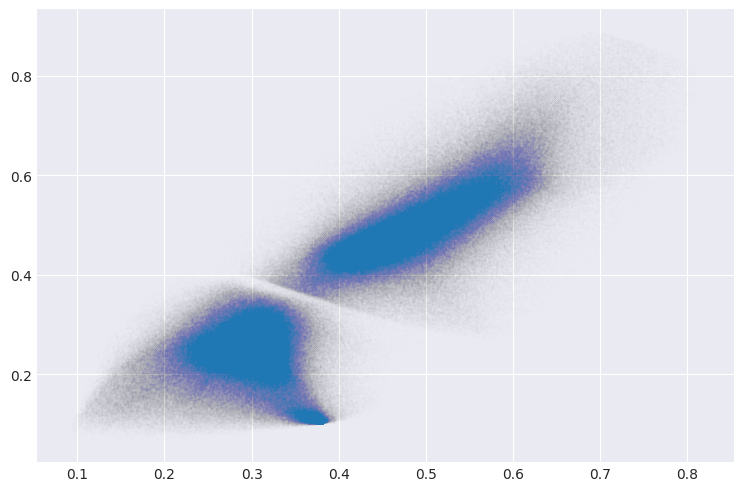

In [157]:
plt.scatter(x, y, alpha=0.006, s=0.1)

## Let's try HDBSCAN (fuck it), Affinity propagation (fuck it) and Mean shift (this one is ok)

In [165]:
from hdbscan import HDBSCAN
from collections import Counter

In [192]:
from sklearn.cluster import MeanShift, AffinityPropagation
from sklearn.manifold import TSNE

In [159]:
hdb = HDBSCAN()

In [187]:
aff = AffinityPropagation()

In [170]:
ms = MeanShift()

In [199]:
lil_shit_ind = np.random.choice(np.array(range(len(dec.train_data["final"]))), 3000)
lil_shit = dec.train_data["final"][lil_shit_ind]

In [160]:
labels = hdb.fit_predict(dec.train_data["final"])

What the fuck were that labels???

In [185]:
ms_labels=ms.fit_predict(lil_shit)

In [190]:
aff_labels=aff.fit_predict(lil_shit)

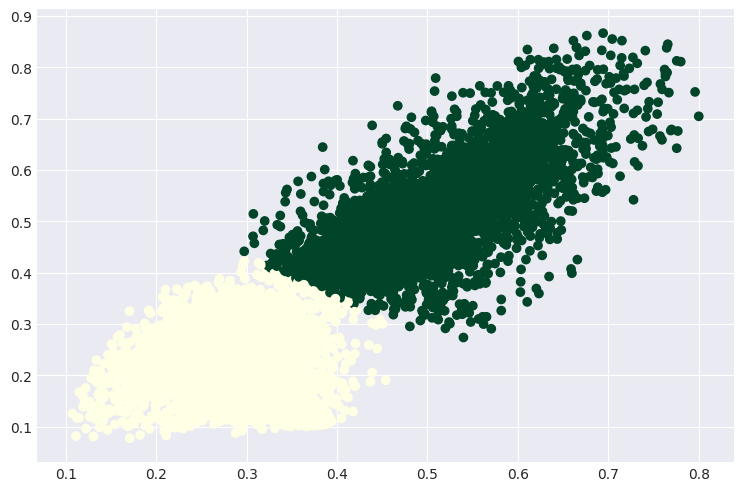

In [186]:
plt.scatter(*zip(*lil_shit), c=ms_labels, cmap="YlGn")

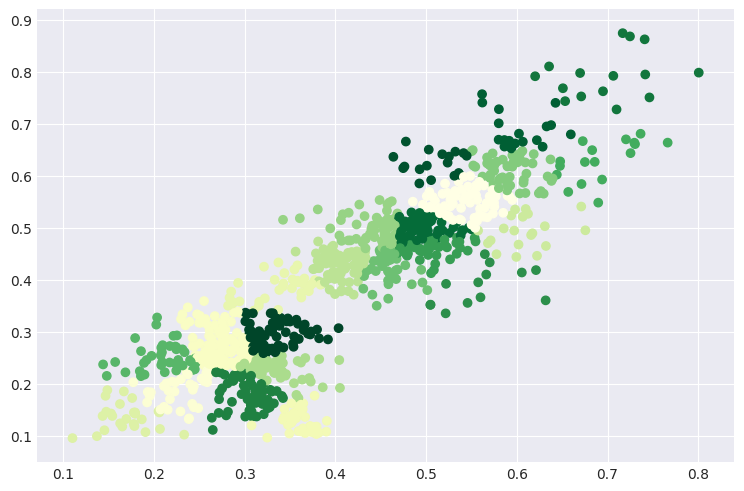

In [191]:
plt.scatter(*zip(*lil_shit), c=aff_labels, cmap="YlGn")

In [200]:
tsne = TSNE()

In [201]:
tsne_table = tsne.fit_transform(lil_shit)

In [203]:
x, y = zip(*tsne_table)

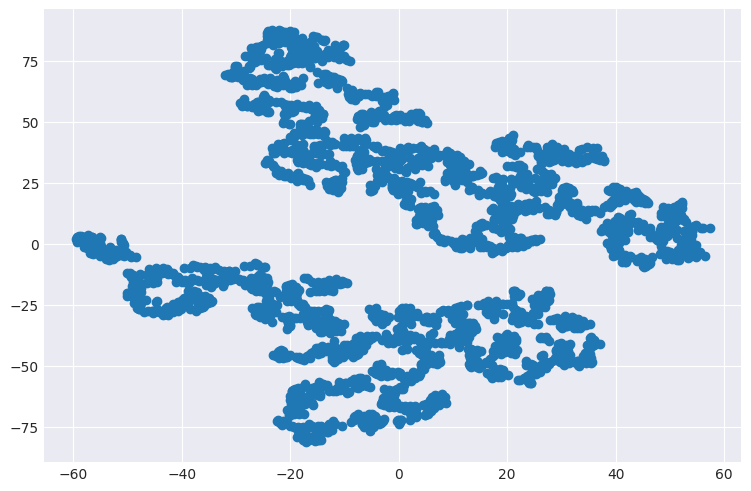

In [204]:
plt.scatter(x, y)

In [166]:
counter = Counter(labels)

In [168]:
counter.most_common(10)

[(-1, 772237),
 (25624, 347),
 (26616, 303),
 (56053, 282),
 (17694, 234),
 (30710, 216),
 (52841, 203),
 (26042, 202),
 (26665, 188),
 (26509, 186)]

In [10]:
import sklearn as sk

In [14]:
from sklearn import calibration as cal